<a href="https://colab.research.google.com/github/bharat-mullapudi/LSTM_SOC_RUL/blob/main/RUL_like_soc_working_review5RULLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
import seaborn as sns
import glob


In [ ]:

df = pd.read_excel('/content/drive/MyDrive/LSTM_SOC_Implementation/RUL/CS2_35/CS2_35_9_8_10.xlsx',sheet_name=1)

In [ ]:
df

,Data_Point,Test_Time(s),Date_Time,Step_Time(s),Step_Index,Cycle_Index,Current(A),Voltage(V),Charge_Capacity(Ah),Discharge_Capacity(Ah),Charge_Energy(Wh),Discharge_Energy(Wh),dV/dt(V/s),Internal_Resistance(Ohm),Is_FC_Data,AC_Impedance(Ohm),ACI_Phase_Angle(Deg)
0,1,30.000557,2010-09-07 10:44:17,30.000557,1,1,0.000000,3.790244,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0
1,2,60.015781,2010-09-07 10:44:47,60.015781,1,1,0.000000,3.790082,0.000000,0.000000,0.000000,0.000000,-0.000065,0.000000,0,0,0
2,3,90.031038,2010-09-07 10:45:17,90.031039,1,1,0.000000,3.790082,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0
3,4,120.014352,2010-09-07 10:45:47,120.014353,1,1,0.000000,3.790244,0.000000,0.000000,0.000000,0.000000,0.000032,0.000000,0,0,0
4,5,150.014995,2010-09-07 10:46:17,30.000210,2,1,0.550297,3.874587,0.004585,0.000000,0.017725,0.000000,0.000389,0.000000,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2345,2346,80602.391928,2010-09-08 09:07:17,2881.449956,7,7,-1.099568,3.502897,6.908082,7.055547,27.570612,25.856896,-0.000130,0.092305,0,0,0
2346,2347,80632.407308,2010-09-08 09:07:47,2911.465336,7,7,-1.099388,3.497069,6.908082,7.064715,27.570612,25.888982,-0.000130,0.092305,0,0,0
2347,2348,80662.422450,2010-09-08 09:08:17,2941.480478,7,7,-1.099568,3.490756,6.908082,7.073883,27.570612,25.921014,-0.000194,0.092305,0,0,0
2348,2349,80692.437586,2010-09-08 09:08:47,2971.495614,7,7,-1.099568,3.484118,6.908082,7.083050,27.570612,25.952988,-0.000227,0.092305,0,0,0


In [4]:
df.describe()

NameError: ignored

In [6]:
def drop_outlier(array,count,bins):
    index = []
    range_ = np.arange(1,count,bins)
    for i in range_[:-1]:
        array_lim = array[i:i+bins]
        sigma = np.std(array_lim)
        mean = np.mean(array_lim)
        th_max,th_min = mean + sigma*2, mean - sigma*2
        idx = np.where((array_lim < th_max) & (array_lim > th_min))
        idx = idx[0] + i
        index.extend(list(idx))
    return np.array(index)

In [7]:
Battery_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']

dir_path = '/content/drive/MyDrive/LSTM_SOC_Implementation/RUL/'
Battery = {}
for name in Battery_list:
    print('Load Dataset ' + name + ' ...')
    path = glob.glob(dir_path + name + '/*.xlsx')
    dates = []
    for p in path:
        df = pd.read_excel(p, sheet_name=1)
        #print('Load ' + str(p) + ' ...')
        dates.append(df['Date_Time'][0])
    idx = np.argsort(dates)
    path_sorted = np.array(path)[idx]
    
    count = 0
    discharge_capacities = []
    health_indicator = []
    internal_resistance = []
    CCCT = []
    CVCT = []

    for p in path_sorted:
        df = pd.read_excel(p,sheet_name=1)
        #print('Load ' + str(p) + ' ...')
        cycles = list(set(df['Cycle_Index']))
        for c in cycles:
            df_lim = df[df['Cycle_Index'] == c]

            #Charging
            df_c = df_lim[(df_lim['Step_Index'] == 2)|(df_lim['Step_Index'] == 4)]
            c_v = df_c['Voltage(V)']
            c_c = df_c['Current(A)']
            c_t = df_c['Test_Time(s)']
            #CC or CV
            df_cc = df_lim[df_lim['Step_Index'] == 2]
            df_cv = df_lim[df_lim['Step_Index'] == 4]
            CCCT.append(np.max(df_cc['Test_Time(s)'])-np.min(df_cc['Test_Time(s)']))
            CVCT.append(np.max(df_cv['Test_Time(s)'])-np.min(df_cv['Test_Time(s)']))

            #Discharging
            df_d = df_lim[df_lim['Step_Index'] == 7]
            d_v = df_d['Voltage(V)']
            d_c = df_d['Current(A)']
            d_t = df_d['Test_Time(s)']
            d_im = df_d['Internal_Resistance(Ohm)']

            if(len(list(d_c)) != 0):
                time_diff = np.diff(list(d_t))
                d_c = np.array(list(d_c))[1:]
                discharge_capacity = time_diff*d_c/3600 # Q = A*h
                discharge_capacity = [np.sum(discharge_capacity[:n]) for n in range(discharge_capacity.shape[0])]
                discharge_capacities.append(-1*discharge_capacity[-1])

                dec = np.abs(np.array(d_v) - 3.8)[1:]
                start = np.array(discharge_capacity)[np.argmin(dec)]
                dec = np.abs(np.array(d_v) - 3.4)[1:]
                end = np.array(discharge_capacity)[np.argmin(dec)]
                health_indicator.append(-1 * (end - start))

               # health_indicator.append(1.1+(discharge_capacity))

                internal_resistance.append(np.mean(np.array(d_im)))
                count += 1

    discharge_capacities = np.array(discharge_capacities)
    #health_indicator=np.array(max(discharge_capacities)-)
    health_indicator = np.array(health_indicator)
    internal_resistance = np.array(internal_resistance)
    CCCT = np.array(CCCT)
    CVCT = np.array(CVCT)
    
    idx = drop_outlier(discharge_capacities, count, 40)
    df_result = pd.DataFrame({'cycle':np.linspace(1,idx.shape[0],idx.shape[0]),
                              'capacity':discharge_capacities[idx],
                              'SoH':health_indicator[idx],
                              'resistance':internal_resistance[idx],
                              'CCCT':CCCT[idx],
                              'CVCT':CVCT[idx],})
    Battery[name] = df_result

Load Dataset CS2_35 ...
Load Dataset CS2_36 ...
Load Dataset CS2_37 ...
Load Dataset CS2_38 ...


In [8]:
type(Battery)

dict

In [9]:
type(Battery['CS2_35'])

pandas.core.frame.DataFrame

In [10]:
Battery['CS2_35'].head()

,cycle,capacity,SoH,resistance,CCCT,CVCT
0,1.0,1.126385,0.825175,0.094009,6613.059052,2251.498033
1,2.0,1.126160,0.815965,0.091661,6612.402800,2231.967052
2,3.0,1.125966,0.815977,0.094649,6608.560673,2228.216959
3,4.0,1.118508,0.825194,0.091413,6604.732222,2247.561061
4,5.0,1.117210,0.806900,0.091413,6629.211049,2077.692393


In [ ]:
Battery

{'CS2_35':      cycle  capacity       SoH  resistance         CCCT         CVCT
 0      1.0  1.126385  0.825175    0.094009  6613.059052  2251.498033
 1      2.0  1.126160  0.815965    0.091661  6612.402800  2231.967052
 2      3.0  1.125966  0.815977    0.094649  6608.560673  2228.216959
 3      4.0  1.118508  0.825194    0.091413  6604.732222  2247.561061
 4      5.0  1.117210  0.806900    0.091413  6629.211049  2077.692393
 ..     ...       ...       ...         ...          ...          ...
 877  878.0  0.339218  0.128353    0.121454  1255.711238          NaN
 878  879.0  0.330025  0.128343    0.122852  1535.380556  3328.912803
 879  880.0  0.330027  0.119175    0.120863  1291.478395  3022.668035
 880  881.0  0.320860  0.119175    0.122264  1290.025300  3007.262188
 881  882.0  0.320863  0.119174    0.123185  1264.996494  3010.181684
 
 [882 rows x 6 columns],
 'CS2_36':      cycle  capacity       SoH  resistance         CCCT         CVCT
 0      1.0  1.133807  0.825405    0.091628

In [11]:
df35=Battery['CS2_35']
df36=Battery['CS2_36']
df37=Battery['CS2_37']
df38=Battery['CS2_38']


eol_index_35= df35.query('capacity < 0.77').index.tolist()[0] #index of eol
eol_index_36= df36.query('capacity < 0.77').index.tolist()[0] #index of eol
eol_index_37= df37.query('capacity < 0.77').index.tolist()[0] #index of eol
eol_index_38= df38.query('capacity < 0.77').index.tolist()[0] #index of eol

print(eol_index_35)
print(eol_index_36)
print(eol_index_37)
print(eol_index_38)

640
520
716
745


In [12]:
B35=Battery['CS2_35'].head(eol_index_35)
B36=Battery['CS2_36'].head(eol_index_36)
B37=Battery['CS2_37'].head(eol_index_37)
B38=Battery['CS2_38'].head(eol_index_38)


In [13]:
B35_1=B35.drop(['SoH'], axis=1) 
B36_1=B36.drop(['SoH'], axis=1) 
B37_1=B37.drop(['SoH'], axis=1) 
B38_1=B38.drop(['SoH'], axis=1) 

In [14]:
# using apply function to create a new column RUL
B35_1['RUL'] = B35_1.apply(lambda row: eol_index_35 - (row.cycle), axis = 1)
B36_1['RUL'] = B36_1.apply(lambda row: eol_index_36 - (row.cycle), axis = 1)
B37_1['RUL'] = B37_1.apply(lambda row: eol_index_37 - (row.cycle), axis = 1)
B38_1['RUL'] = B38_1.apply(lambda row: eol_index_38 - (row.cycle), axis = 1)


In [16]:
#add battery IDs 1,2,3,4
B35_1['battery_id'] = B35_1.apply(lambda row: 1, axis = 1)
B36_1['battery_id'] = B36_1.apply(lambda row: 2, axis = 1)
B37_1['battery_id'] = B37_1.apply(lambda row: 3, axis = 1)
B38_1['battery_id'] = B38_1.apply(lambda row: 4, axis = 1)


In [18]:
B38_1

,cycle,capacity,resistance,CCCT,CVCT,RUL,battery_id
0,1.0,1.126964,0.102498,6585.419024,2359.168730,744.0,4
1,2.0,1.126642,0.104031,6572.075291,2361.918249,743.0,4
2,3.0,1.126019,0.104654,6566.714960,2362.605960,742.0,4
3,4.0,1.124355,0.104031,6560.136514,2381.011933,741.0,4
4,5.0,1.123409,0.101592,6612.742838,2194.316027,740.0,4
...,...,...,...,...,...,...,...
740,741.0,0.806703,0.100689,4578.578228,2545.394396,4.0,4
741,742.0,0.806696,0.101317,4588.767382,2530.583433,3.0,4
742,743.0,0.806701,0.099244,4558.219950,2595.422010,2.0,4
743,744.0,0.806713,0.099786,4471.292708,2631.794967,1.0,4


In [31]:
combined_battery_df = pd.concat([B35_1,B36_1, B37_1, B38_1],ignore_index=True)
combined_battery_df

,cycle,capacity,resistance,CCCT,CVCT,RUL,battery_id
0,1.0,1.126385,0.094009,6613.059052,2251.498033,639.0,1
1,2.0,1.126160,0.091661,6612.402800,2231.967052,638.0,1
2,3.0,1.125966,0.094649,6608.560673,2228.216959,637.0,1
3,4.0,1.118508,0.091413,6604.732222,2247.561061,636.0,1
4,5.0,1.117210,0.091413,6629.211049,2077.692393,635.0,1
...,...,...,...,...,...,...,...
2616,741.0,0.806703,0.100689,4578.578228,2545.394396,4.0,4
2617,742.0,0.806696,0.101317,4588.767382,2530.583433,3.0,4
2618,743.0,0.806701,0.099244,4558.219950,2595.422010,2.0,4
2619,744.0,0.806713,0.099786,4471.292708,2631.794967,1.0,4


In [32]:
cols = list(combined_battery_df.columns)
cols = [cols[-1]] + cols[:-1]
combined_battery_df_1 = combined_battery_df[cols]
combined_battery_df_1

,battery_id,cycle,capacity,resistance,CCCT,CVCT,RUL
0,1,1.0,1.126385,0.094009,6613.059052,2251.498033,639.0
1,1,2.0,1.126160,0.091661,6612.402800,2231.967052,638.0
2,1,3.0,1.125966,0.094649,6608.560673,2228.216959,637.0
3,1,4.0,1.118508,0.091413,6604.732222,2247.561061,636.0
4,1,5.0,1.117210,0.091413,6629.211049,2077.692393,635.0
...,...,...,...,...,...,...,...
2616,4,741.0,0.806703,0.100689,4578.578228,2545.394396,4.0
2617,4,742.0,0.806696,0.101317,4588.767382,2530.583433,3.0
2618,4,743.0,0.806701,0.099244,4558.219950,2595.422010,2.0
2619,4,744.0,0.806713,0.099786,4471.292708,2631.794967,1.0


## **Training like SoC**

In [34]:
cd2=combined_battery_df_1

In [43]:
y = cd2.RUL
X = cd2.drop(['battery_id','RUL'], axis=1)
print(X)
print(y)
print(X_train.shape)
print(Y_train.shape)

      cycle  capacity  resistance         CCCT         CVCT
0       1.0  1.126385    0.094009  6613.059052  2251.498033
1       2.0  1.126160    0.091661  6612.402800  2231.967052
2       3.0  1.125966    0.094649  6608.560673  2228.216959
3       4.0  1.118508    0.091413  6604.732222  2247.561061
4       5.0  1.117210    0.091413  6629.211049  2077.692393
...     ...       ...         ...          ...          ...
2616  741.0  0.806703    0.100689  4578.578228  2545.394396
2617  742.0  0.806696    0.101317  4588.767382  2530.583433
2618  743.0  0.806701    0.099244  4558.219950  2595.422010
2619  744.0  0.806713    0.099786  4471.292708  2631.794967
2620  745.0  0.806695    0.100780  4431.386866  2622.937564

[2621 rows x 5 columns]
0       639.0
1       638.0
2       637.0
3       636.0
4       635.0
        ...  
2616      4.0
2617      3.0
2618      2.0
2619      1.0
2620      0.0
Name: RUL, Length: 2621, dtype: float64
(2092, 3)
(2092,)


In [38]:
from sklearn.preprocessing import MinMaxScaler


In [39]:
dataset = cd2.RUL.values #numpy.ndarray
dataset = dataset.astype('float64')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [40]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [41]:
# reshape into X=t and Y=t+1
look_back = 3

X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [42]:
print(X_train)
print(Y_train)

[[0.85887097 0.85752688 0.8561828 ]
 [0.85752688 0.8561828  0.85483871]
 [0.8561828  0.85483871 0.85349462]
 ...
 [0.71370968 0.71236559 0.71102151]
 [0.71236559 0.71102151 0.70967742]
 [0.71102151 0.70967742 0.70833333]]
[0.85483871 0.85349462 0.85215054 ... 0.70967742 0.70833333 0.70698925]


In [44]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [56]:
X_test.shape

(521, 1, 3)

In [50]:
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model



In [51]:
model = Sequential()
#model.add(LSTM(,return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.01))
model.add(Dense(2))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=100, batch_size=1, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=50), ModelCheckpoint(filepath='best_model0.h5', monitor='val_loss', save_best_only=True)], verbose=1, shuffle=False)

# Training Phase
model.summary()

Epoch 1/100
2092/2092 [==============================] - 8s 3ms/step - loss: 0.0173 - val_loss: 0.0020
Epoch 2/100
2092/2092 [==============================] - 6s 3ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 3/100
2092/2092 [==============================] - 5s 3ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 4/100
2092/2092 [==============================] - 6s 3ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 5/100
2092/2092 [==============================] - 5s 3ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 6/100
2092/2092 [==============================] - 5s 3ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 7/100
2092/2092 [==============================] - 5s 3ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 8/100
2092/2092 [==============================] - 5s 2ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 9/100
2092/2092 [==============================] - 5s 2ms/step - loss: 0.0014 - val_loss: 9.0804e-04
Epoch 10/100
2092/2092 [==============================] - 6s 3ms/step

In [52]:
# make predictions
saved_model = load_model('best_model0.h5')
train_predict = saved_model.predict(X_train)
test_predict = saved_model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 10.47400354347539
Train Root Mean Squared Error: 23.808870640501933
Test Mean Absolute Error: 5.864869784942744
Test Root Mean Squared Error: 10.748459211652124


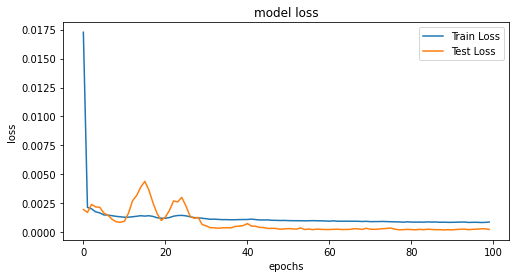

In [53]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

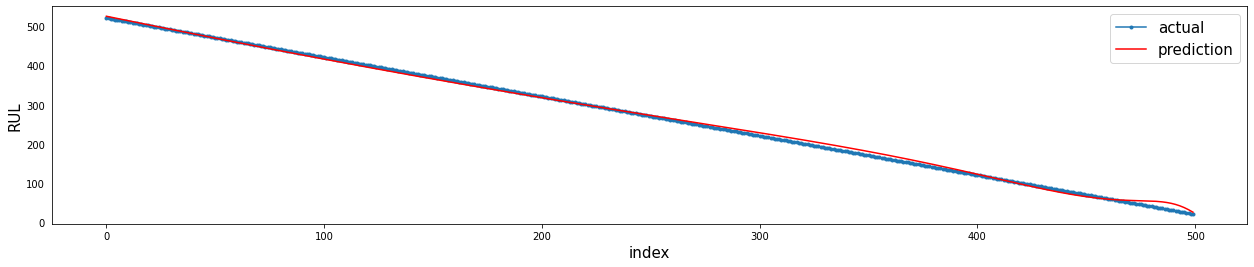

In [63]:
aa=[x for x in range(500)]
plt.figure(figsize=(20,4))
plt.plot(aa, Y_test[0][:500], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:500], 'r', label="prediction")
plt.tick_params(left=False, labelleft=True) #remove ticks
#plt.tight_layout()
#sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('RUL', size=15)
#plt.ylim((0,1))
plt.xlabel('index', size=15)
plt.legend(fontsize=15)
plt.show();

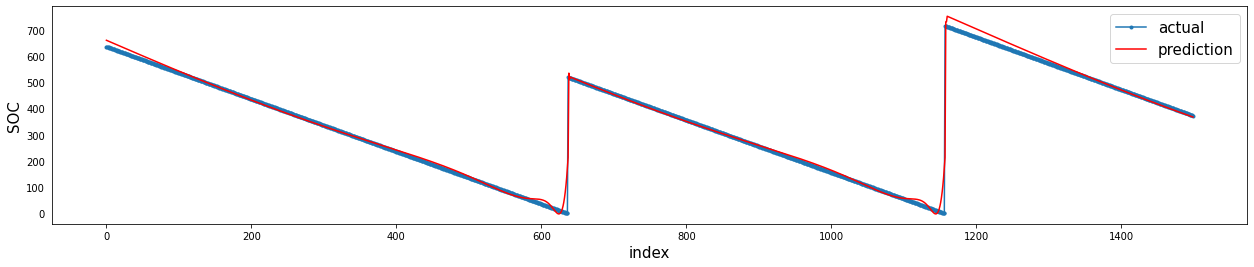

In [62]:
aa=[x for x in range(1500)]
plt.figure(figsize=(20,4))
plt.plot(aa, Y_train[0][:1500], marker='.', label="actual")
plt.plot(aa, train_predict[:,0][:1500], 'r', label="prediction")
plt.tick_params(left=False, labelleft=True) #remove ticks
#plt.tight_layout()
#sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('SOC', size=15)
#plt.ylim((0,1))
plt.xlabel('index', size=15)
plt.legend(fontsize=15)
plt.show();

In [ ]:
np.linspace(1,idx.shape[0],idx.shape[0])

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100., 101., 102., 103., 104., 105., 106., 107., 108., 109., 110.,
       111., 112., 113., 114., 115., 116., 117., 118., 119., 120., 121.,
       122., 123., 124., 125., 126., 127., 128., 129., 130., 131., 132.,
       133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143.,
       144., 145., 146., 147., 148., 149., 150., 15

In [ ]:
(discharge_capacities)

array([1.13795092, 1.12696392, 1.12664237, ..., 0.28419883, 0.29336473,
       0.28419511])

In [ ]:
health_indicator

array([0.82899   , 0.83423941, 0.83421979, ..., 0.08250824, 0.09167263,
       0.08250517])

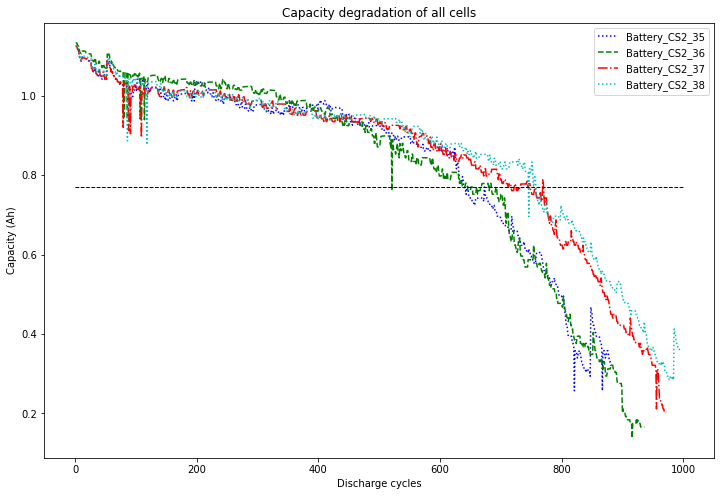

In [ ]:
Rated_Capacity = 1.1
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c:']
for name,color in zip(Battery_list, color_list):
    battery = Battery[name]
    ax.plot(battery['cycle'], battery['capacity'], color, label='Battery_'+name)
plt.plot([-1,1000],[Rated_Capacity*0.7, Rated_Capacity*0.7], c='black', lw=1, ls='--') # critical point line
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation of all cells')
plt.legend()

In [ ]:
battery = Battery['CS2_36']
ax = plt.axes(projection='3d')
ax.plot_surface(battery['cycle'], battery['SoH'],battery['resistance'], rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('surface');

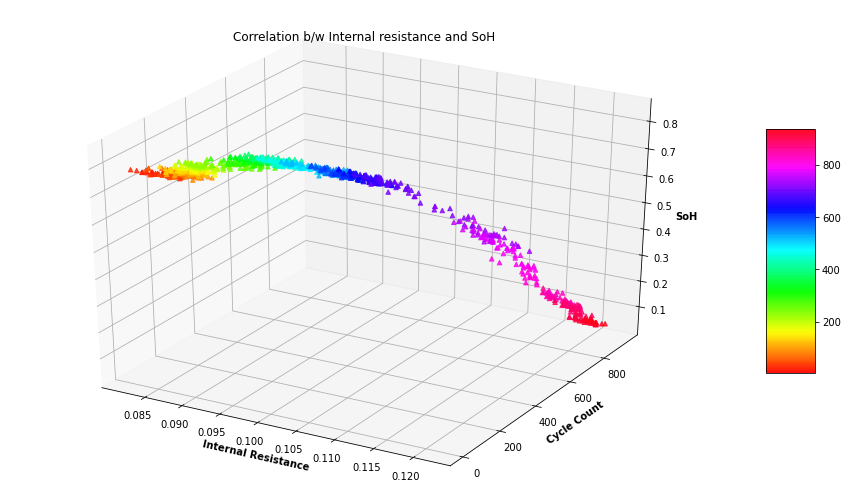

In [ ]:
battery = Battery['CS2_36']

# Import libraries
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
 
 
# Creating dataset
x =battery['resistance']
y = battery['cycle']
z = battery['SoH']

# Creating figure
fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")
   
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)
 
 
# Creating color map
my_cmap = plt.get_cmap('hsv')
 
# Creating plot
sctt = ax.scatter3D(x, y, z,
                    alpha = 0.8,
                    c = (x + y + z),
                    cmap = my_cmap,
                    marker ='^')
 
plt.title("Correlation b/w Internal resistance and SoH")
ax.set_xlabel('Internal Resistance', fontweight ='bold')
ax.set_ylabel('Cycle Count', fontweight ='bold')
ax.set_zlabel('SoH', fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
 
# show plot
plt.show()

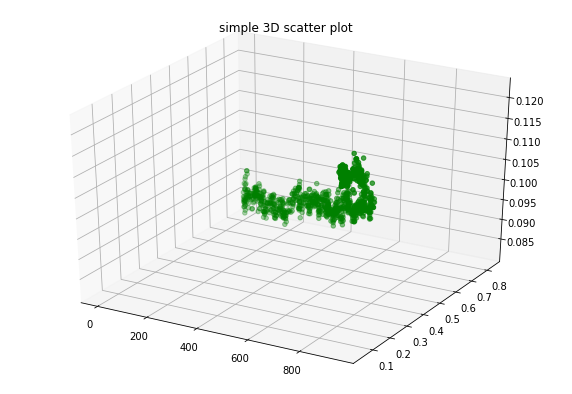

In [ ]:
battery = Battery['CS2_36']
#plt.figure(figsize=(9,6))
#plt.scatter(battery['cycle'], battery['SoH'], c=battery['resistance'], s=10)

# Import libraries
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
 
 
# Creating dataset
z =battery['resistance']
x = battery['cycle']
y = battery['SoH']
 
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(x, y, z, color = "green")
plt.title("simple 3D scatter plot")
 
# show plot
plt.show()

Text(0, 0.5, 'State of Health')

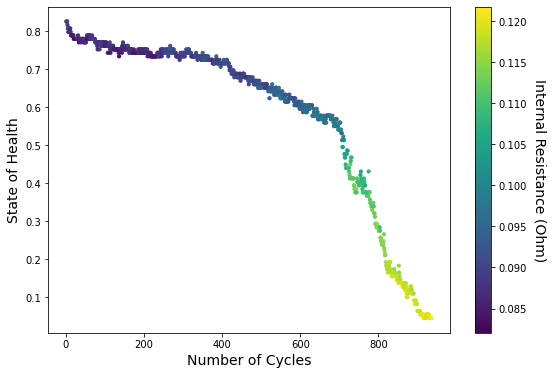

In [ ]:
battery = Battery['CS2_36']
plt.figure(figsize=(9,6))
plt.scatter(battery['cycle'], battery['SoH'], c=battery['resistance'], s=10)
cbar = plt.colorbar()
cbar.set_label('Internal Resistance (Ohm)', fontsize=14, rotation=-90, labelpad=20)
plt.xlabel('Number of Cycles', fontsize=14)
plt.ylabel('State of Health', fontsize=14)

Text(0, 0.5, 'CV Charging Time(sec)')

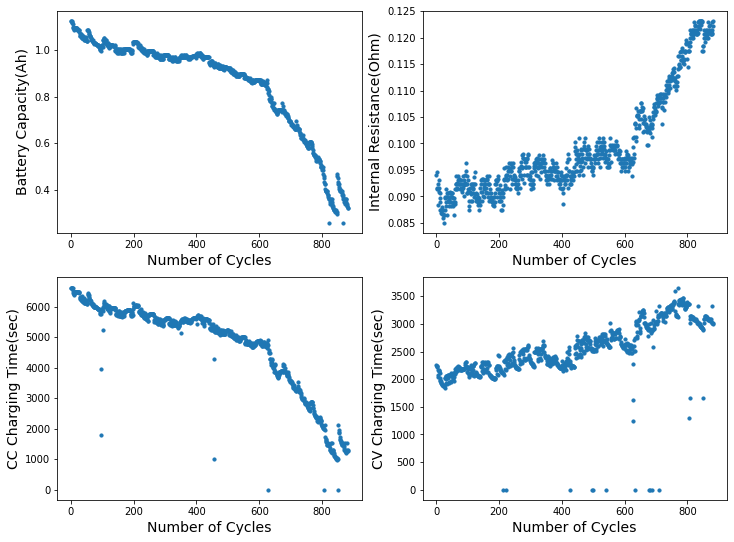

In [ ]:
battery = Battery['CS2_35']
plt.figure(figsize=(12,9))
names = ['capacity', 'resistance', 'CCCT', 'CVCT']
#for i in range(4):
plt.subplot(2, 2, 1)
plt.scatter(battery['cycle'], battery['capacity'], s=10)
plt.xlabel('Number of Cycles', fontsize=14)
plt.ylabel('Battery Capacity(Ah)', fontsize=14)

plt.subplot(2, 2, 2)
plt.scatter(battery['cycle'], battery['resistance'], s=10)
plt.xlabel('Number of Cycles', fontsize=14)
plt.ylabel('Internal Resistance(Ohm)', fontsize=14)

plt.subplot(2, 2, 3)
plt.scatter(battery['cycle'], battery['CCCT'], s=10)
plt.xlabel('Number of Cycles', fontsize=14)
plt.ylabel('CC Charging Time(sec)', fontsize=14)
  
plt.subplot(2, 2, 4)
plt.scatter(battery['cycle'], battery['CVCT'], s=10)
plt.xlabel('Number of Cycles', fontsize=14)
plt.ylabel('CV Charging Time(sec)', fontsize=14)

In [ ]:
for i in range(4):
  print(i)

0
1
2
3


In [ ]:
!pip3 install torch torchvision

In [ ]:
import sklearn

In [ ]:
import numpy as np
import random
import math
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
%matplotlib inline

from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [ ]:
def drop_outlier(array,count,bins):
    index = []
    range_ = np.arange(1,count,bins)
    for i in range_[:-1]:
        array_lim = array[i:i+bins]
        sigma = np.std(array_lim)
        mean = np.mean(array_lim)
        th_max,th_min = mean + sigma*2, mean - sigma*2
        idx = np.where((array_lim < th_max) & (array_lim > th_min))
        idx = idx[0] + i
        index.extend(list(idx))
    return np.array(index)


def build_sequences(text, window_size):
    #text:list of capacity
    x, y = [],[]
    for i in range(len(text) - window_size):
        sequence = text[i:i+window_size]
        target = text[i+1:i+1+window_size] #seq, target are same size
        x.append(sequence)
        y.append(target)
    print("printing x,y..")    
    print(x)
    print(y)
    return np.array(x), np.array(y)



# Leave one for evaluation: one set of data is the test set, and all other data are used for training
def get_train_test(data_dict, name, window_size=8):
    data_sequence=data_dict[name]['capacity']
    train_data, test_data = data_sequence[:window_size+1], data_sequence[window_size+1:]
    train_x, train_y = build_sequences(text=train_data, window_size=window_size)
    for k, v in data_dict.items(): #key,value pair in dict.
        if k != name:
            data_x, data_y = build_sequences(text=v['capacity'], window_size=window_size)
            train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]
    print("printing train_data,test_data..")    
    print(train_data)
    print(test_data)        
    return train_x, train_y, list(train_data), list(test_data)


def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), 0
    for i in range(len(y_test)-1):
        if y_test[i] <= threshold >= y_test[i+1]:
            true_re = i - 1
            break
    for i in range(len(y_predict)-1):
        if y_predict[i] <= threshold:
            pred_re = i - 1
            break
    return abs(true_re - pred_re)/true_re if abs(true_re - pred_re)/true_re<=1 else 1


def evaluation(y_test, y_predict):
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return mae, rmse
    
    
def setup_seed(seed):
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed) # To disable hash randomization and make the experiment reproducible.
    torch.manual_seed(seed)# Set random seed for CPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)# Set a random seed for the current GPU
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU，Set random seeds for all GPUs
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

In [ ]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_dim, num_layers, n_class=1, mode='LSTM'):
        super(Net, self).__init__()
        self.cell = nn.LSTM(input_size=input_size, hidden_size=hidden_dim, 
                            num_layers=num_layers, batch_first=True)
        if mode == 'GRU':
            self.cell = nn.GRU(input_size=input_size, hidden_size=hidden_dim, 
                               num_layers=num_layers, batch_first=True)
        elif mode == 'RNN':
            self.cell = nn.RNN(input_size=input_size, hidden_size=hidden_dim, 
                               num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, n_class)

    def forward(self, x):           # x shape: (batch_size, seq_len, input_size)
        out, _ = self.cell(x) 
        out = out.reshape(-1, hidden_dim)
        out = self.linear(out)      # out shape: (batch_size, n_class=1)
        return out


In [ ]:
def tain(lr=0.001, 
         feature_size=16, 
         hidden_dim=128, 
         num_layers=2, 
         weight_decay=0.0, 
         mode='LSTM', 
         EPOCH=1000, 
         seed=0):
    score_list, result_list = [], []
    for i in range(4):
        name = Battery_list[i]  #Battery_list is like ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38'] each battery in list have : capacity, SoH, resistance, CCCT, CVCT in order.

        train_x, train_y, train_data, test_data = get_train_test(
            Battery, name, window_size=feature_size)
        train_size = len(train_x)

        #print(train_x,tr_y,tr_dta,tst_data sizes to observe)


        print('---------------------\\\\\\\\\\\\\\\\\--------------------')


        print('train_x:')
        print(train_x)
        print('train_y:')
        print(train_y)
        print('train_data:')
        print(train_data)
        print('test_data:')
        print(test_data)

        print('---------------------\\\\\\\\\\\\\\\\\--------------------')


        print('sample size: {}'.format(train_size))

        setup_seed(seed)
        model = Net(input_size=feature_size, 
                    hidden_dim=hidden_dim, 
                    num_layers=num_layers, 
                    mode=mode)

        optimizer = torch.optim.Adam(model.parameters(), 
                                     lr=lr, weight_decay=weight_decay)
        criterion = nn.MSELoss()

        test_x = train_data.copy()
        loss_list, y_ = [0], []
        mae, rmse, re = 1, 1, 1
        score_, score = 1,1
        for epoch in range(EPOCH):
            X = np.reshape(train_x/Rated_Capacity,(-1, 1, feature_size)
                          ).astype(np.float32) #(batch_size, seq_len, input_size)
            y = np.reshape(train_y[:,-1]/Rated_Capacity,(-1,1)).astype(np.float32)

            X, y = torch.from_numpy(X), torch.from_numpy(y)
            output= model(X)
            output = output.reshape(-1, 1)
            loss = criterion(output, y)
            optimizer.zero_grad()              # clear gradients for this training step
            loss.backward()                    # backpropagation, compute gradients
            optimizer.step()                   # apply gradients

            if (epoch + 1)%100 == 0:
                test_x = train_data.copy()   # re-predict every 100 times
                point_list = []
                while (len(test_x) - len(train_data)) < len(test_data):
                    x = np.reshape(np.array(test_x[-feature_size:])/Rated_Capacity,
                                   (-1, 1, feature_size)).astype(np.float32)
                    x = torch.from_numpy(x)  # shape: (batch_size, 1, input_size)
                    pred = model(x)
                    next_point = pred.data.numpy()[0,0] * Rated_Capacity
                    test_x.append(next_point)    #The test value is added to the original sequence to continue to predict the next point
                    point_list.append(next_point)#Save the predicted value of the last point in the output sequence
                y_.append(point_list)           #Save all forecast values ​​for this forecast
                loss_list.append(loss)
                mae, rmse = evaluation(y_test=test_data, y_predict=y_[-1])
                re = relative_error(y_test=test_data, 
                                    y_predict=y_[-1], threshold=Rated_Capacity*0.7)
                print('epoch:{:<2d} | loss:{:<6.4f} | MAE:{:<6.4f} | \
                      RMSE:{:<6.4f} | RE:{:<6.4f}'.format(epoch, loss, mae, rmse, re))
            score = [re, mae, rmse]
            if (loss < 1e-3) and (score_[0] < score[0]):
                break
            score_ = score.copy()

        score_list.append(score_)
        result_list.append(y_[-1])
    return score_list, result_list


In [ ]:
window_size = 16
EPOCH = 1000
lr = 0.01#from 0.001    # learning rate  0.01 epoch 10
hidden_dim = 128
num_layers = 2
weight_decay = 0.0
mode = 'LSTM'# RNN, LSTM, GRU
Rated_Capacity = 1.1

SCORE = []
for seed in range(10):
    print('seed: ', seed)
    score_list, _ = tain(lr=lr, feature_size=window_size, hidden_dim=hidden_dim, num_layers=num_layers, 
                         weight_decay=weight_decay, mode=mode, EPOCH=EPOCH, seed=seed)
    print('------------------------------------------------------------------')
    for s in score_list:
        SCORE.append(s)

mlist = ['re', 'mae', 'rmse']
for i in range(3):
    s = [line[i] for line in SCORE]
    print(mlist[i] + ' mean: {:<6.4f}'.format(np.mean(np.array(s))))
print('------------------------------------------------------------------')
print('------------------------------------------------------------------')

Streaming output truncated to the last 5000 lines.
656    0.833415
657    0.833890
658    0.816063
659    0.816063
660    0.816025
661    0.815980
662    0.815619
663    0.816034
Name: capacity, dtype: float64, 649    0.843516
650    0.834350
651    0.825193
652    0.825166
653    0.825184
654    0.824627
655    0.824325
656    0.833415
657    0.833890
658    0.816063
659    0.816063
660    0.816025
661    0.815980
662    0.815619
663    0.816034
664    0.824731
Name: capacity, dtype: float64, 650    0.834350
651    0.825193
652    0.825166
653    0.825184
654    0.824627
655    0.824325
656    0.833415
657    0.833890
658    0.816063
659    0.816063
660    0.816025
661    0.815980
662    0.815619
663    0.816034
664    0.824731
665    0.825025
Name: capacity, dtype: float64, 651    0.825193
652    0.825166
653    0.825184
654    0.824627
655    0.824325
656    0.833415
657    0.833890
658    0.816063
659    0.816063
660    0.816025
661    0.815980
662    0.815619
663    0.816034
664  

In [ ]:
print(train_data)

NameError: ignored

In [ ]:
y_test;

In [ ]:
aa=[x for x in range(20000)]
plt.figure(figsize=(20,4))
plt.plot(aa, Y_test[0][:20000], marker='.', label="actual")
plt.plot(aa, y_predict[:,0][:20000], 'r', label="prediction")
plt.tick_params(left=False, labelleft=True) #remove ticks
#plt.tight_layout()
#sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('SOC', size=15)
plt.ylim((0,1))
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();